In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
#Necessary Libraries.
import pandas as pd
import numpy as np

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sci

# Multicollinearity test and treatment Libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

## data preprocessing and EDA libraries 
from collections import OrderedDict 
from sklearn.preprocessing import StandardScaler

#Model Selection Libraries
from sklearn.model_selection import train_test_split , cross_val_score, GridSearchCV

#ML Models
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
import xgboost
from xgboost import XGBRegressor

#Model Evaluation Libraries
from sklearn.metrics import r2_score, mean_squared_error

# Warning filter library
import warnings
warnings.filterwarnings('ignore')


In [3]:
df = pd.read_csv("miami-housing.csv")

In [4]:
df.head()

LATITUDE  LONGITUDE      PARCELNO  SALE_PRC  LND_SQFOOT  TOT_LVG_AREA  \
0  25.891031 -80.160561  622280070620  440000.0        9375          1753   
1  25.891324 -80.153968  622280100460  349000.0        9375          1715   
2  25.891334 -80.153740  622280100470  800000.0        9375          2276   
3  25.891765 -80.152657  622280100530  988000.0       12450          2058   
4  25.891825 -80.154639  622280100200  755000.0       12800          1684   

   SPEC_FEAT_VAL  RAIL_DIST  OCEAN_DIST  WATER_DIST  CNTR_DIST  SUBCNTR_DI  \
0              0     2815.9     12811.4       347.6    42815.3     37742.2   
1              0     4359.1     10648.4       337.8    43504.9     37340.5   
2          49206     4412.9     10574.1       297.1    43530.4     37328.7   
3          10033     4585.0     10156.5         0.0    43797.5     37423.2   
4          16681     4063.4     10836.8       326.6    43599.7     37550.8   

   HWY_DIST  age  avno60plus  month_sold  structure_quality  
0   15954.9   67           0           8                  4  
1   18125.0   63           0           9                  4  
2   18200.5   61           0           2                  4  
3   18514.4   63           0           9                  4  
4   17903.4   42           0           7                  4

In [5]:
df.shape

(13932, 17)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13932 entries, 0 to 13931
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LATITUDE           13932 non-null  float64
 1   LONGITUDE          13932 non-null  float64
 2   PARCELNO           13932 non-null  int64  
 3   SALE_PRC           13932 non-null  float64
 4   LND_SQFOOT         13932 non-null  int64  
 5   TOT_LVG_AREA       13932 non-null  int64  
 6   SPEC_FEAT_VAL      13932 non-null  int64  
 7   RAIL_DIST          13932 non-null  float64
 8   OCEAN_DIST         13932 non-null  float64
 9   WATER_DIST         13932 non-null  float64
 10  CNTR_DIST          13932 non-null  float64
 11  SUBCNTR_DI         13932 non-null  float64
 12  HWY_DIST           13932 non-null  float64
 13  age                13932 non-null  int64  
 14  avno60plus         13932 non-null  int64  
 15  month_sold         13932 non-null  int64  
 16  structure_quality  139

## Creating Check function to check which integer value features should be treated as an categorical feature.

In [7]:
def check(my_df):
    df_int = my_df.select_dtypes(include = "int64")
    check = []
    for col in df_int.columns:
        stats = OrderedDict({
            "Feature Name": col,
            "Count":df_int[col].count(),
            "Unique Values":df_int[col].unique().shape[0]
            })
        check.append(stats)
    
    check_df = pd.DataFrame(check)
    return check_df

In [8]:
check(df)

Feature Name  Count  Unique Values
0           PARCELNO  13932          13776
1         LND_SQFOOT  13932           4696
2       TOT_LVG_AREA  13932           2978
3      SPEC_FEAT_VAL  13932           7583
4                age  13932             96
5         avno60plus  13932              2
6         month_sold  13932             12
7  structure_quality  13932              5

Analysis:
1. PARCELNO has almost all unique values means it is acting like index here which is not required.
2. age has 96 unique values - therefore, treating as numerical feature.
3. avno60plus, month_sold, structure_quality - will be treated as categorical feature.

In [9]:
#removing PARCELNO .
df.drop("PARCELNO", axis=1, inplace=True)

#spliting data in numerical and categorical feature.
cat_col = ["avno60plus", "month_sold", "structure_quality"]
df_num = df.drop(cat_col, axis=1)
df_cat = df[cat_col]

In [10]:
df_num.head()

LATITUDE  LONGITUDE  SALE_PRC  LND_SQFOOT  TOT_LVG_AREA  SPEC_FEAT_VAL  \
0  25.891031 -80.160561  440000.0        9375          1753              0   
1  25.891324 -80.153968  349000.0        9375          1715              0   
2  25.891334 -80.153740  800000.0        9375          2276          49206   
3  25.891765 -80.152657  988000.0       12450          2058          10033   
4  25.891825 -80.154639  755000.0       12800          1684          16681   

   RAIL_DIST  OCEAN_DIST  WATER_DIST  CNTR_DIST  SUBCNTR_DI  HWY_DIST  age  
0     2815.9     12811.4       347.6    42815.3     37742.2   15954.9   67  
1     4359.1     10648.4       337.8    43504.9     37340.5   18125.0   63  
2     4412.9     10574.1       297.1    43530.4     37328.7   18200.5   61  
3     4585.0     10156.5         0.0    43797.5     37423.2   18514.4   63  
4     4063.4     10836.8       326.6    43599.7     37550.8   17903.4   42

In [11]:
df_cat.head()

avno60plus  month_sold  structure_quality
0           0           8                  4
1           0           9                  4
2           0           2                  4
3           0           9                  4
4           0           7                  4

- Analysis of Stage 1
1. There are 13932 rows and 14 columns
2. PARCELNO column is been removed because it had mostly unique values.
3. there are 10 numerical and 3 categorical independent features.
4. SALE_PRC is the target feature.
5. There no missing values.
6. EDA on LATITUDE and LONGITUDE columns will be treated seperately as they conveys location of the house, Means no outlier treatment for them.

## EDA on Numerical Feature.

In [12]:
#df_num

In [13]:
def custom_summary(my_df):
    result = my_df.describe().T
    
    #Skewness value and Comment
    skew = []
    for col in my_df.columns:
        skew.append(my_df[col].skew())
    result["Skewness value"] = skew
    
    skew_comment = []
    for col in my_df.columns:
        if -1 > my_df[col].skew():
            skew_comment.append("Highly Negatively skewed")
        elif -1 <= my_df[col].skew() < -0.5:
            skew_comment.append("Moderately Negatively Skewed")
        elif -0.5 <= my_df[col].skew() < 0:
            skew_comment.append("fairly Negatively skewed")
        elif 0 < my_df[col].skew() <= 0.5:
            skew_comment.append("fairly Positively skewed")
        elif 0.5 < my_df[col].skew() <= 1:
            skew_comment.append("Moderately Positively skewed")
        else : skew_comment.append("Highly Positively skewed")
            
    result["Skewness comment"] = skew_comment
    
    #Kurtosis value and comment.
    kurtosis = []
    for col in my_df.columns:
        kurtosis.append(my_df[col].kurt())
    result["Kurtosis"] = kurtosis
    
    kurtosis_label=[]
    for i in result['Kurtosis']:
        if i >= 1:
            kurtosis_label.append('Leptokurtic Curve')
        elif i <= -1:
            kurtosis_label.append('Platykurtic Curve')
        else:
            kurtosis_label.append('Mesokurtic Curve')
    result['Kurtosis Comment'] = kurtosis_label
    
    return result

In [14]:
custom_summary(df_num)

count           mean            std           min  \
LATITUDE       13932.0      25.728811       0.140633     25.434333   
LONGITUDE      13932.0     -80.327475       0.089199    -80.542172   
SALE_PRC       13932.0  399941.931740  317214.683816  72000.000000   
LND_SQFOOT     13932.0    8620.879917    6070.088742   1248.000000   
TOT_LVG_AREA   13932.0    2058.044574     813.538535    854.000000   
SPEC_FEAT_VAL  13932.0    9562.493468   13890.967782      0.000000   
RAIL_DIST      13932.0    8348.548715    6178.027333     10.500000   
OCEAN_DIST     13932.0   31690.993798   17595.079468    236.100000   
WATER_DIST     13932.0   11960.285235   11932.992369      0.000000   
CNTR_DIST      13932.0   68490.327132   32008.474808   3825.600000   
SUBCNTR_DI     13932.0   41115.047265   22161.825935   1462.800000   
HWY_DIST       13932.0    7723.770693    6068.936108     90.200000   
age            13932.0      30.669251      21.153068      0.000000   

                         25%            50%            75%           max  \
LATITUDE           25.620056      25.731810      25.852269  2.597438e+01   
LONGITUDE         -80.403278     -80.338911     -80.258019 -8.011975e+01   
SALE_PRC       235000.000000  310000.000000  428000.000000  2.650000e+06   
LND_SQFOOT       5400.000000    7500.000000    9126.250000  5.706400e+04   
TOT_LVG_AREA     1470.000000    1877.500000    2471.000000  6.287000e+03   
SPEC_FEAT_VAL     810.000000    2765.500000   12352.250000  1.750200e+05   
RAIL_DIST        3299.450000    7106.300000   12102.600000  2.962150e+04   
OCEAN_DIST      18079.350000   28541.750000   44310.650000  7.574490e+04   
WATER_DIST       2675.850000    6922.600000   19200.000000  5.039980e+04   
CNTR_DIST       42823.100000   65852.400000   89358.325000  1.599765e+05   
SUBCNTR_DI      23996.250000   41109.900000   53949.375000  1.105538e+05   
HWY_DIST         2998.125000    6159.750000   10854.200000  4.816730e+04   
age                14.000000      26.000000      46.000000  9.600000e+01   

               Skewness value              Skewness comment   Kurtosis  \
LATITUDE            -0.094570      fairly Negatively skewed  -0.969276   
LONGITUDE            0.292592      fairly Positively skewed  -0.908129   
SALE_PRC             3.215506      Highly Positively skewed  13.275156   
LND_SQFOOT           3.830115      Highly Positively skewed  19.076805   
TOT_LVG_AREA         1.346930      Highly Positively skewed   2.487290   
SPEC_FEAT_VAL        1.902250      Highly Positively skewed   4.667249   
RAIL_DIST            0.824282  Moderately Positively skewed  -0.012673   
OCEAN_DIST           0.393140      fairly Positively skewed  -0.690381   
WATER_DIST           1.138049      Highly Positively skewed   0.328991   
CNTR_DIST            0.427598      fairly Positively skewed  -0.313939   
SUBCNTR_DI           0.454150      fairly Positively skewed  -0.211261   
HWY_DIST             1.116250      Highly Positively skewed   1.102694   
age                  0.505014  Moderately Positively skewed  -0.653131   

                Kurtosis Comment  
LATITUDE        Mesokurtic Curve  
LONGITUDE       Mesokurtic Curve  
SALE_PRC       Leptokurtic Curve  
LND_SQFOOT     Leptokurtic Curve  
TOT_LVG_AREA   Leptokurtic Curve  
SPEC_FEAT_VAL  Leptokurtic Curve  
RAIL_DIST       Mesokurtic Curve  
OCEAN_DIST      Mesokurtic Curve  
WATER_DIST      Mesokurtic Curve  
CNTR_DIST       Mesokurtic Curve  
SUBCNTR_DI      Mesokurtic Curve  
HWY_DIST       Leptokurtic Curve  
age             Mesokurtic Curve

Analysis:
1. Features have either Leptokurtic or Mesokurtic curve.
2. Features with Leptokurtic Curve - SALE_PRC, LND_SQFOOT, TOT_LVG_AREA, 'SPEC_FEAT_VAL, 'HWY_DIST.
   - Insights : The Data points in these feature are closer to mean hence S.D is Low and Mean can be the central Tendancy for them.
3. Features with MesoKurtic Curve - 'RAIL_DIST', 'OCEAN_DIST', 'WATER_DIST', 'CNTR_DIST', 'SUBCNTR_DI', 'AGE'.
   - Insights : The Data points in these features are at moderate distance from their mean .
4. All the features are Positively skewed with different Intensity like(moderatily , fairly and Highly) this implies that outliers possibility is in upper region.

## Making a Fucntion to check which feature requires PD treatment.

In [15]:
# PD-percentile Distribution method.

def method(my_df, col, method ="IQR"):
    col_data = my_df[col]
    #iqr
    if method == "IQR":
        q1 = col_data.quantile(0.25)
        q2 = col_data.quantile(0.50)
        q3 = col_data.quantile(0.75)
        iqr = q3 - q1
        LW = q1 - 1.5*iqr
        UW = q3 + 1.5*iqr
    
    elif method == "Standard Deviation":
        mean = col_data.mean()
        std = col_data.std()
        LW = mean - 2*std
        UW = mean + 2*std
    
    else: print("pass the correct strategy")
        
    outliers = len(my_df.loc[(col_data < LW) | (col_data > UW)])
    outliers_percent = round(outliers/len(my_df), 2)* 100
    
    return outliers, outliers_percent
        

In [16]:
def custom_method(my_df):
    result = pd.DataFrame()
    result["Features"] = my_df.columns
    
    outlier = []
    outlier_percent = []
    #IQR method.
    for col in my_df.columns:
        out, out_p = method(my_df, col, method="IQR")
        outlier.append(out)
        outlier_percent.append(out_p)
    result["Outliers_IQR"] = outlier
    result["Outliers%_IQR"] = outlier_percent
    
    #outlier = []
    #outlier_percent = []
    #S.D method. - This Method is applicable only for Normal distributions.
    #for col in my_df.columns:
       # out, out_p = method(my_df, col, method="Standard Deviation")
       #  outlier.append(out)
       # outlier_percent.append(out_p)
    #result["Outliers_S.D"] = outlier
    #result["Outliers%_S.D"] = outlier_percent
    
    #Percentile_distribution comment.
    PD_comment = []
    result["PD_comment"] = np.where((result["Outliers%_IQR"] > 5), "PD required", "Not required")
    
    group = result.groupby('PD_comment')
    
    return group.get_group('PD required')
                                    

In [17]:
custom_method(df_num)

Features  Outliers_IQR  Outliers%_IQR   PD_comment
2       SALE_PRC          1340           10.0  PD required
3     LND_SQFOOT          1370           10.0  PD required
5  SPEC_FEAT_VAL          1703           12.0  PD required

Analysis:
1. For all these Features who had outlier detected by IQR method is over 5% we will deal with them using Percentile Distribution 
  - reason : Outliers are Extreme Values and they are usually in less % in a dataset so detection of outliers with over 5% of data set means they are not outliers but a general trend of that feature.

In [18]:
def PD_treat(my_df, n):
    cols = []
    for col in custom_method(df_num)["Features"]:
        cols.append(col)
    
    x = 0
    y = 1
    result = pd.DataFrame()
    for i in cols:
        first = []
        last = []
        
        for j in range(1,n+1):
            #first
            first.append(my_df[i].quantile(x))
            #second
            last.append(my_df[i].quantile(y))
            x = x+0.01
            y = y-0.01
            
        result[i+"_first"] = first
        result[i+"_last"] = last
    
    return result
        
    

In [19]:
PD_treat(df_num, 20) #Checking first and last 20 quartile values.

SALE_PRC_first  SALE_PRC_last  LND_SQFOOT_first  LND_SQFOOT_last  \
0          72000.0      2650000.0           5050.00         10000.00   
1          98279.0      1850000.0           5135.00          9790.00   
2         115310.0      1478800.0           5203.64          9546.00   
3         127000.0      1260000.0           5250.00          9375.00   
4         136200.0      1150000.0           5330.44          9300.00   
5         145355.0      1019900.0           5400.00          9126.25   
6         152000.0       940000.0           5500.00          9000.00   
7         160000.0       865000.0           5554.37          8908.52   
8         165000.0       800000.0           5640.00          8775.00   
9         170000.0       750000.0           5750.00          8625.00   
10        175820.0       700000.0           5850.00          8512.70   
11        180000.0       660000.0           5992.44          8400.00   
12        185000.0       630000.0           6000.00          8330.24   
13        190000.0       600000.0           6000.00          8250.00   
14        195000.0       580000.0           6046.54          8199.46   
15        200000.0       561415.0           6151.00          8100.00   
16        201000.0       542020.0           6250.00          8025.00   
17        205581.0       525000.0           6343.47          8000.00   
18        210000.0       510000.0           6435.00          7950.00   
19        215000.0       495000.0           6540.00          7875.00   

    SPEC_FEAT_VAL_first  SPEC_FEAT_VAL_last  
0               1904.80             4085.60  
1               1986.71             3898.00  
2               2069.00             3731.98  
3               2134.00             3596.00  
4               2206.64             3446.36  
5               2281.00             3298.00  
6               2374.00             3191.74  
7               2460.00             3078.29  
8               2550.00             2957.00  
9               2675.19             2859.62  
10              2765.50             2765.50  
11              2859.62             2675.19  
12              2957.00             2550.00  
13              3078.29             2460.00  
14              3191.74             2374.00  
15              3298.00             2281.00  
16              3446.36             2206.64  
17              3596.00             2134.00  
18              3731.98             2069.00  
19              3898.00             1986.71

1. for SALE_PRC capping at 98% .
  - first 80% value are under 5lac , next 15% are under 10lac, last 5% occupying 15lac.
2. No outliers in LND_SQFOOT.
3. No Outliers in PEC_FEAT_VAlUE.

## Analysis of the Data .

In [20]:
df_num.head()

LATITUDE  LONGITUDE  SALE_PRC  LND_SQFOOT  TOT_LVG_AREA  SPEC_FEAT_VAL  \
0  25.891031 -80.160561  440000.0        9375          1753              0   
1  25.891324 -80.153968  349000.0        9375          1715              0   
2  25.891334 -80.153740  800000.0        9375          2276          49206   
3  25.891765 -80.152657  988000.0       12450          2058          10033   
4  25.891825 -80.154639  755000.0       12800          1684          16681   

   RAIL_DIST  OCEAN_DIST  WATER_DIST  CNTR_DIST  SUBCNTR_DI  HWY_DIST  age  
0     2815.9     12811.4       347.6    42815.3     37742.2   15954.9   67  
1     4359.1     10648.4       337.8    43504.9     37340.5   18125.0   63  
2     4412.9     10574.1       297.1    43530.4     37328.7   18200.5   61  
3     4585.0     10156.5         0.0    43797.5     37423.2   18514.4   63  
4     4063.4     10836.8       326.6    43599.7     37550.8   17903.4   42

In [21]:
# Reg plot.
def Reg_plots(my_df, col, tcol):
    if col == tcol:
        pass
    else:
        df_num.ax = plt.subplots(figsize = (6,6))
        sns.regplot(x=col, y=tcol, data=my_df)
        plt.title(f'{col} vs Sale price Regression plot')
        plt.show()

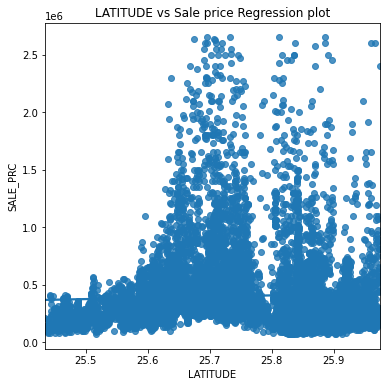

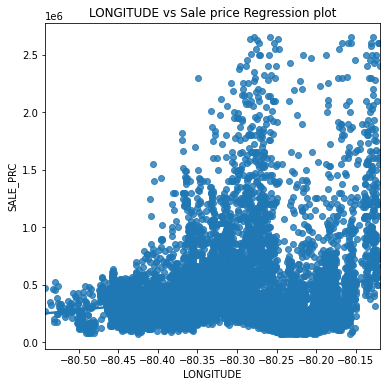

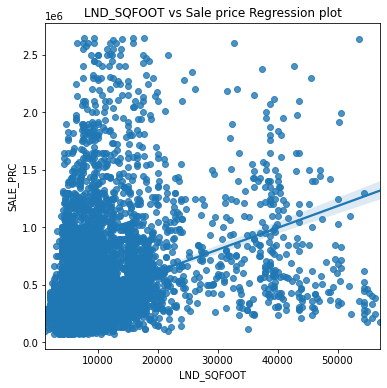

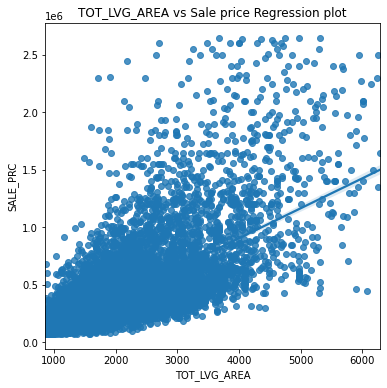

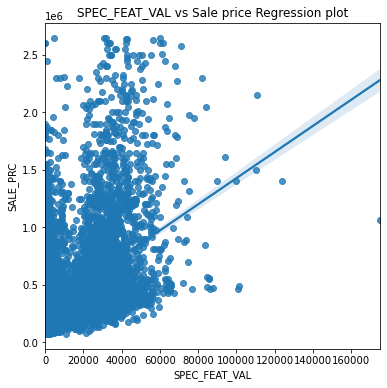

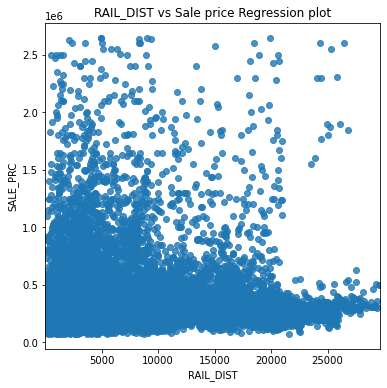

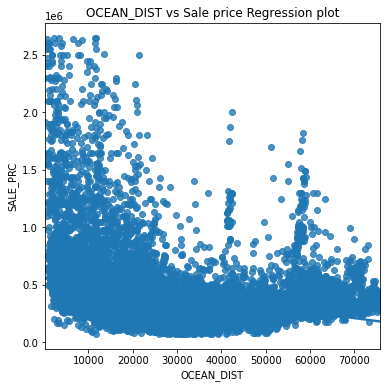

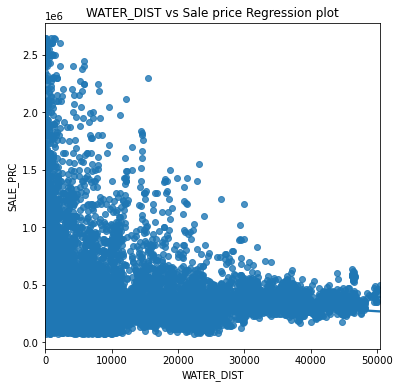

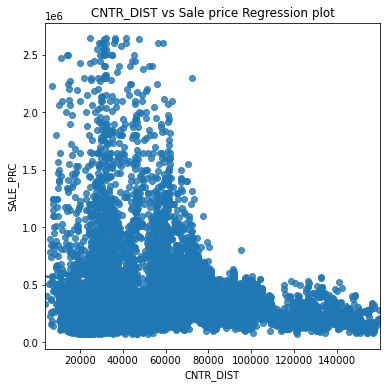

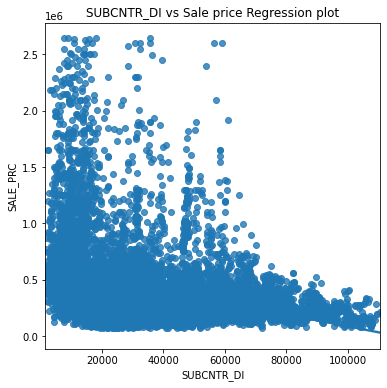

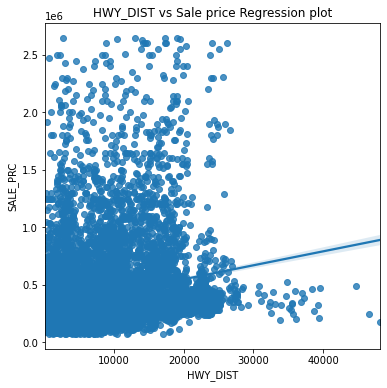

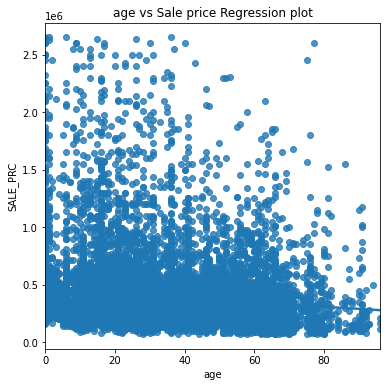

In [22]:
for col in df_num.columns:
    Reg_plots(df_num, col, "SALE_PRC")

1. RAIL_DIST :
   - Expected : Positive relation ,as any house Closer to Railway connectivity will face Noise issue hence price should be lower and keeps on increasing as we move farther from it.
   - Actual outcome - No relation ,it comes out that people are not concern about the noise.
   - reason : Railway conncetivity factor might have compensated the noise factor.
2. CNTR_DIST : it seems people are more concern about Living closer to there workplace hence higher prices near central dist.
3. SUBCNTR_DI : it seems People prefer living closer to sub-center , major concern for health.
4. HWY_DIST :  0 < prefered zone < 30000 feet . within the prefered zone sale price is high means more people prefer to live in this sweet zone. not much closer not much far
5. Age : Less Impactful as per sale price is concern. very less correlation.

In [23]:
#Plotting jett plots.

In [24]:
def jett_plot(my_df, col, tcol):
    if (col=="LONGITUDE") or (col=="LATITUDE") or (col==tcol):
        pass
    else:
        f, (ax1,ax2) = plt.subplots(1,2,figsize=(25,8))
    
        my_df.plot(kind="scatter", x= "LONGITUDE", y="LATITUDE",ax=ax1,
                c = col, cmap=plt.get_cmap('jet'), colorbar=True)
        my_df.plot(kind="scatter", x= "LONGITUDE", y="LATITUDE",ax=ax2,
                c = tcol, cmap=plt.get_cmap('jet'), colorbar=True)
        plt.show()

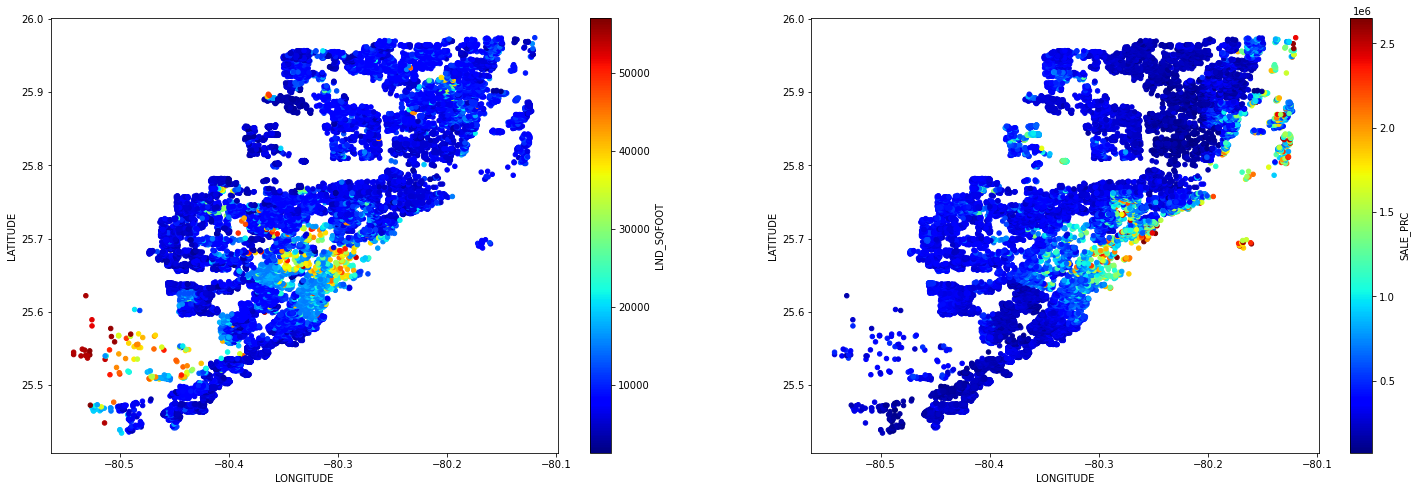

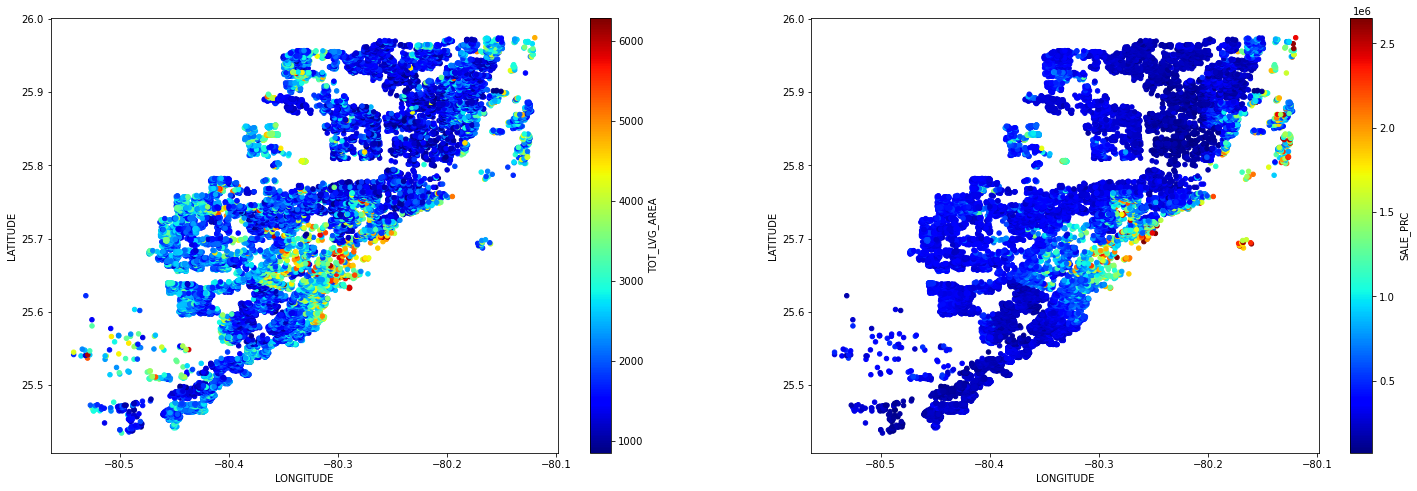

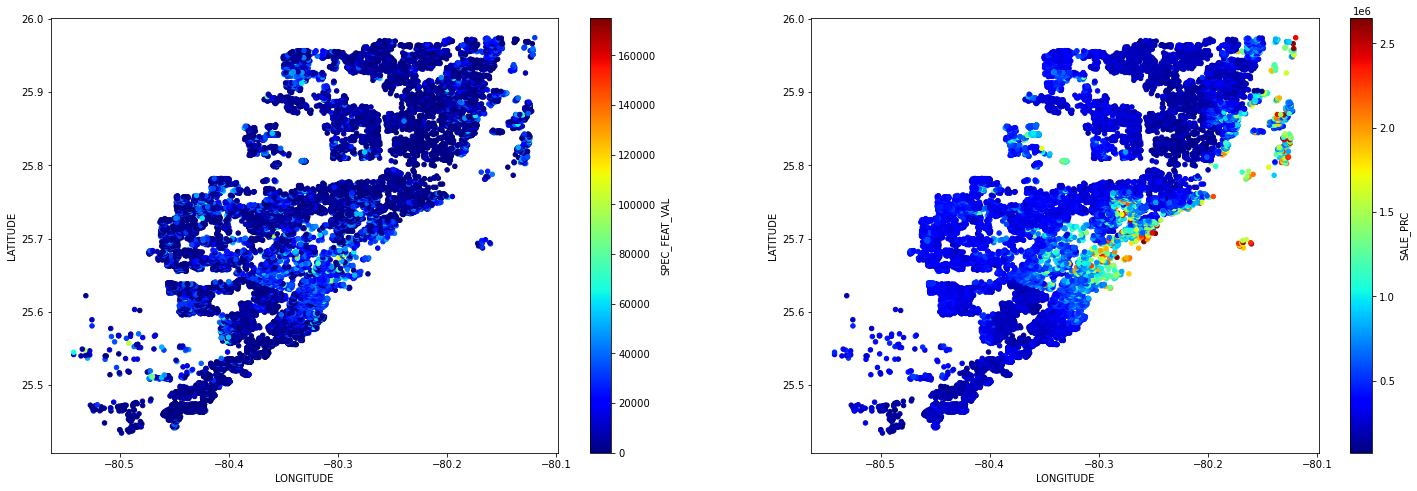

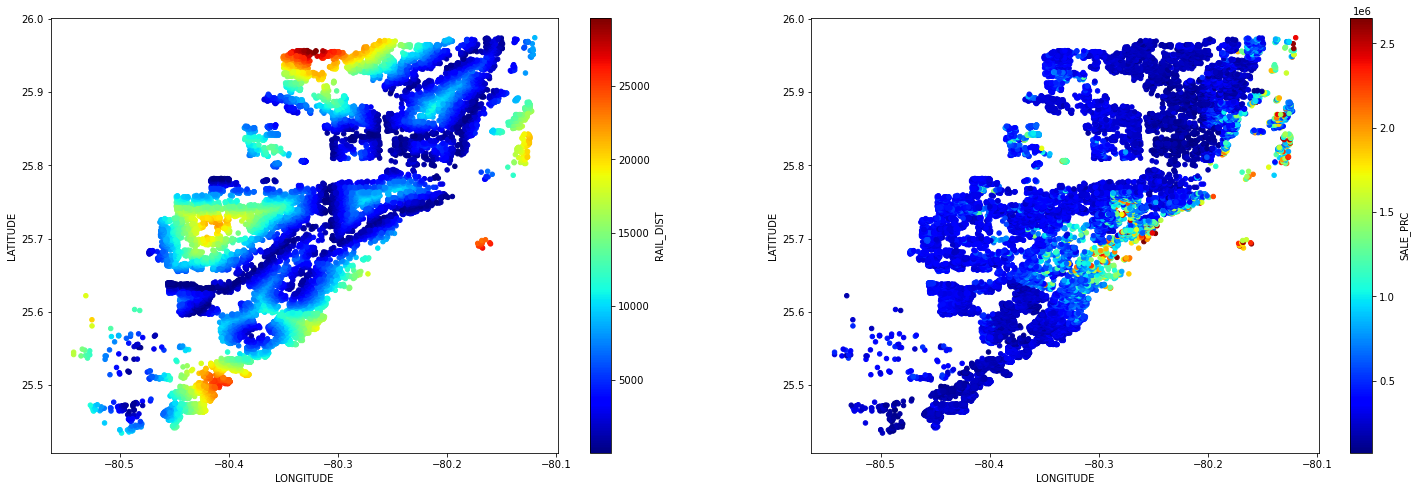

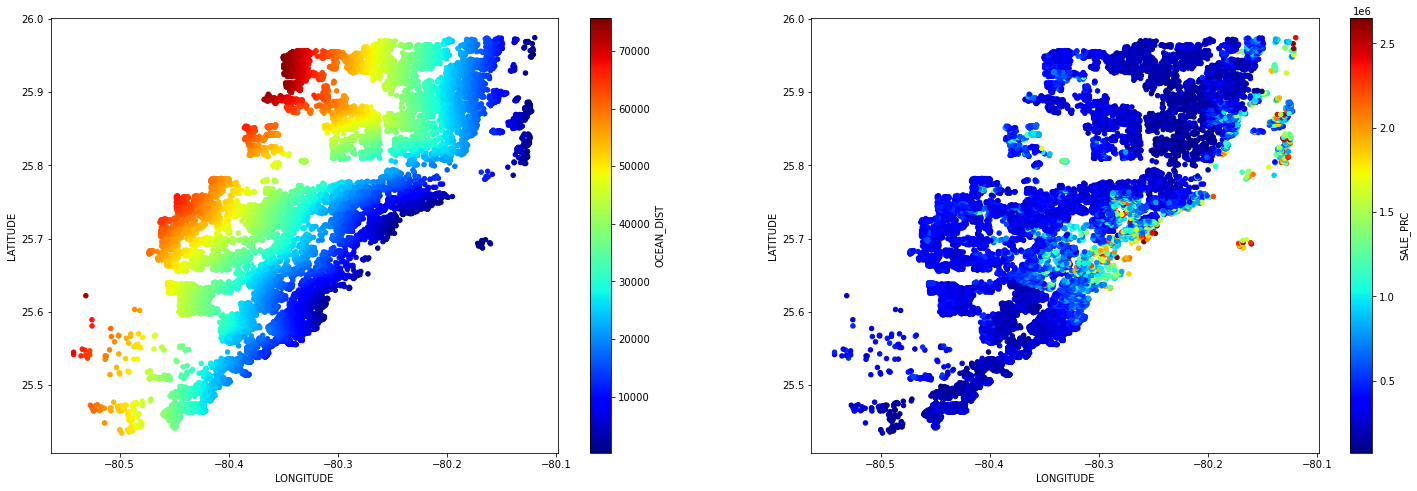

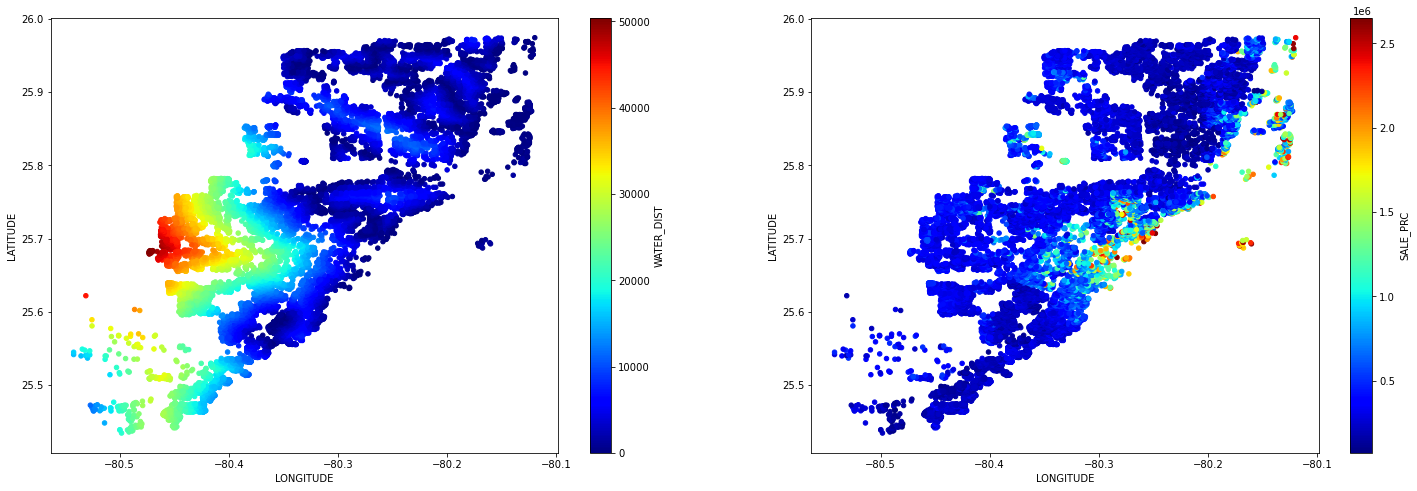

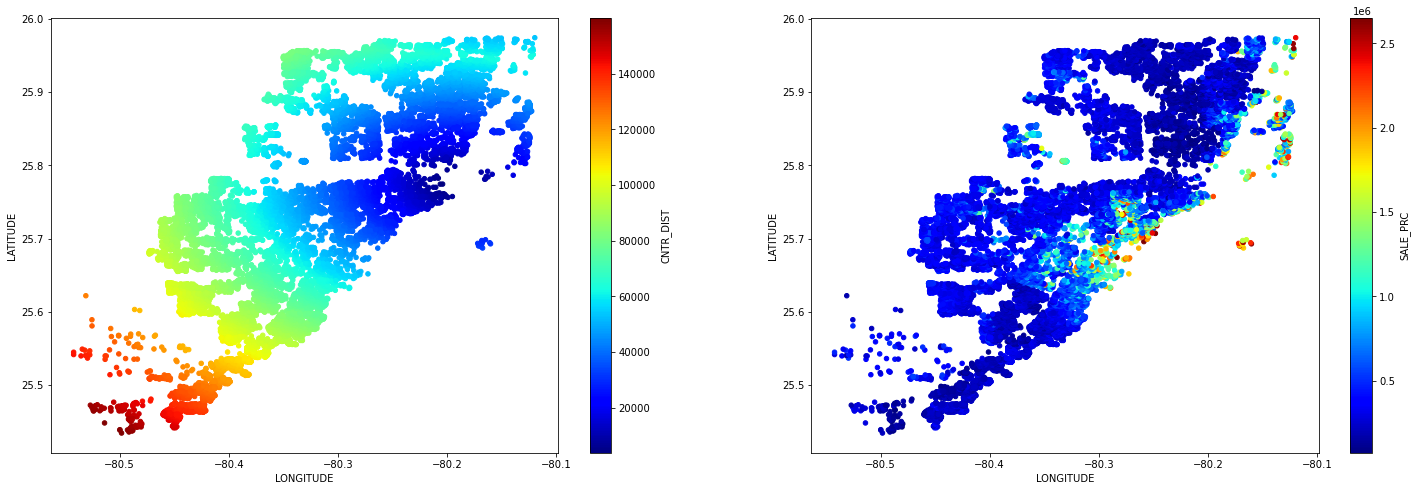

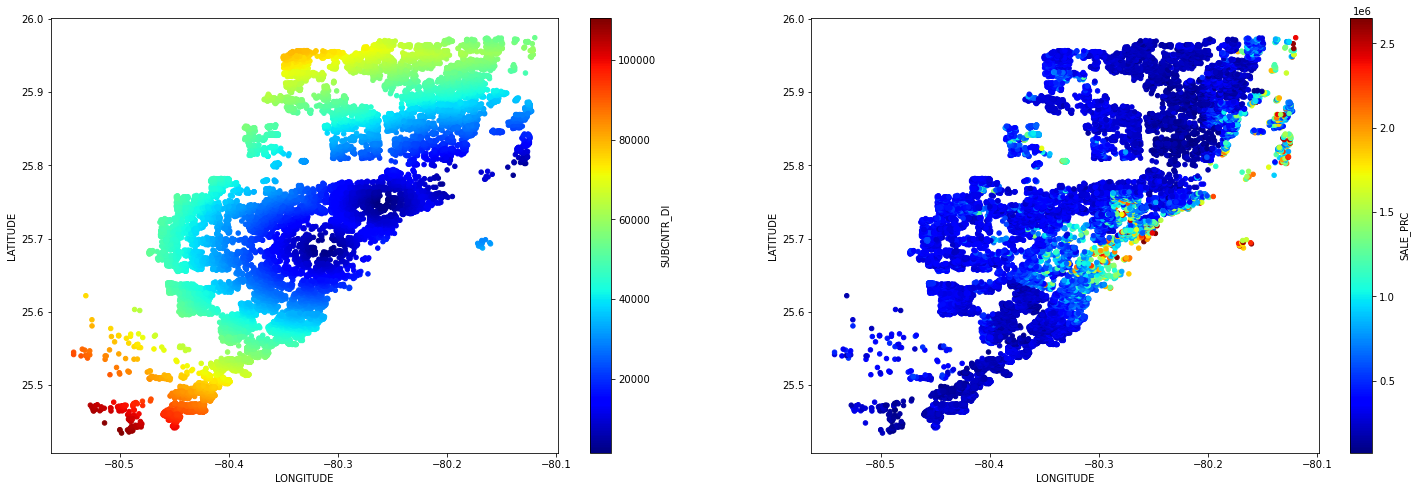

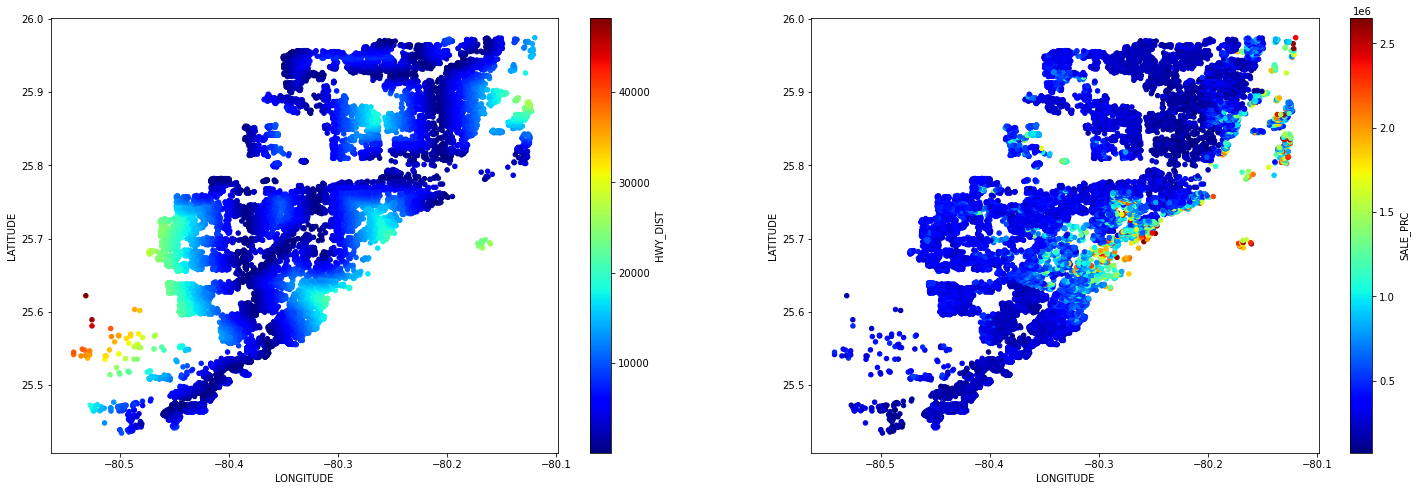

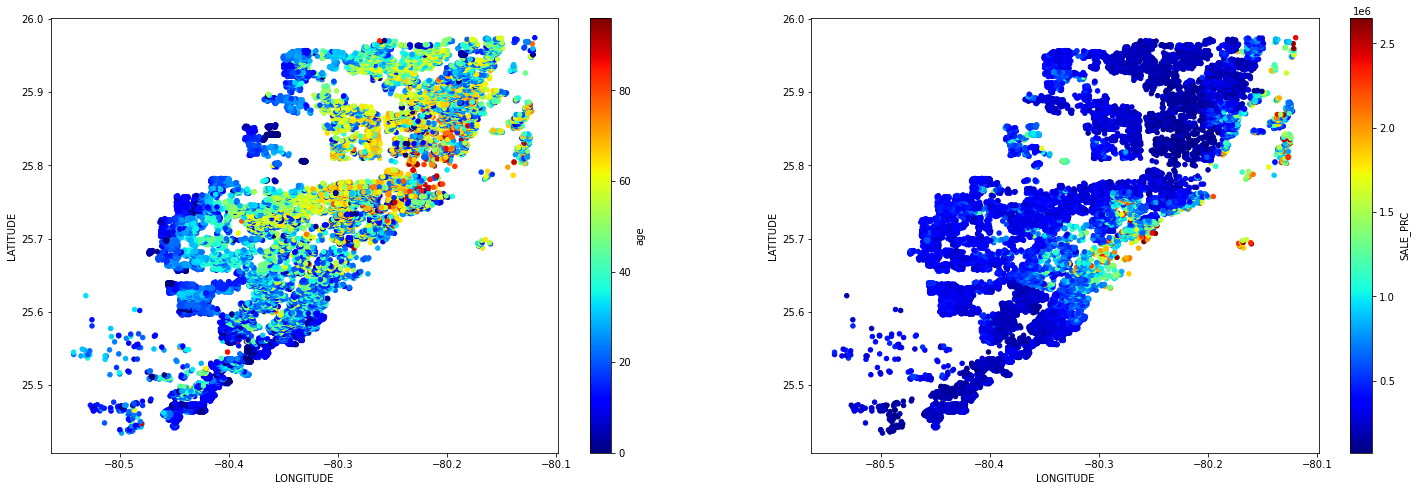

In [25]:
for col in df_num.columns:
    jett_plot(df_num, col, "SALE_PRC")

Findings:
1. OCEAN_DIST : people prefer to live near ocean.
     - The dark blue border is where ocean is and correspondigly we can see prices of house pricisely near that area is high . Highly correlated.
2. WATER_DIST : People are not concern about this.
     - reason : Only time prices of house is high when people are closer to ocean/water ,any other area which might have closer to pond or lake or any other form of waterbodies are entitled with avg pricing ,means ocean is the game changer and WATER_DIST is just taking its records.
3. CNTR_DIST, SUBCNTR_DI : They are closer to the high price region as per the plots means they are important features for deciding house price.
4. TOTAL_LVG_AREA : Another Impacting feature. 
     - apart from border there is a middle region where prices are high even though it is at good distance from the ocean because TOTAL_LVG_AREA of houses pricesely in that region is high.
5. LAND_SQFOOT : Impacting Feature, as somewhat similar to TOTAL_LVG_AREA.
6. Age: Not an Impacting Feature.
7. SPECT_FEAT_VALUE : it is common understanding houses with costly features will cost more.

In [26]:
# Correlation :
def Corr_check(my_df, tcol):
    corr = my_df.corr()
    my_df.ax = plt.subplots(figsize = (15,8))
    sns.heatmap(corr, annot=True)
    
    result = pd.DataFrame()
    result["Features"] = my_df.columns
    result["Correlation"] = corr[tcol].values
    result = result.sort_values(by='Correlation',ascending=False)
    display(result.drop(2, axis=0)) #as 2 is the index of tcol in corr dataframe.
    

Features  Correlation
4    TOT_LVG_AREA     0.667301
5   SPEC_FEAT_VAL     0.497500
3      LND_SQFOOT     0.363077
11       HWY_DIST     0.231877
1       LONGITUDE     0.195274
0        LATITUDE     0.047701
6       RAIL_DIST    -0.077009
12            age    -0.123408
8      WATER_DIST    -0.127938
9       CNTR_DIST    -0.271425
7      OCEAN_DIST    -0.274675
10     SUBCNTR_DI    -0.370078

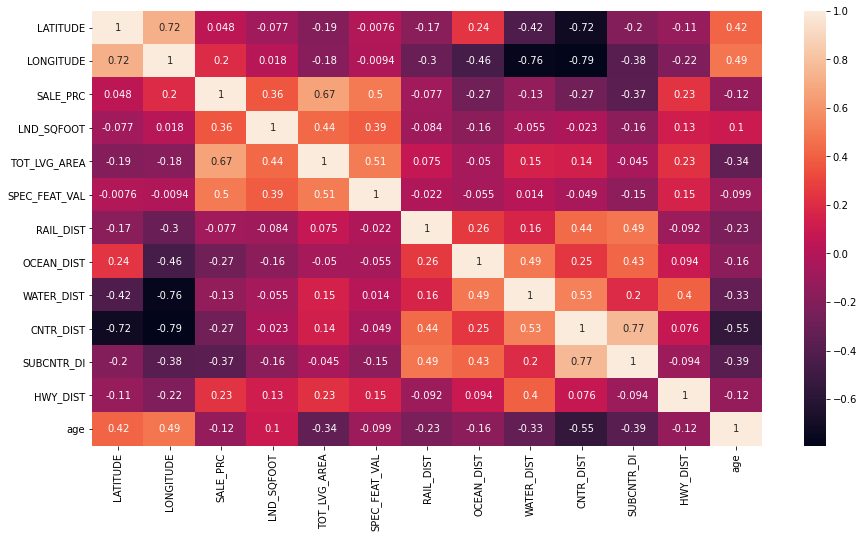

In [27]:
Corr_check(df_num, "SALE_PRC")

Correlation values are exactly prooving our Analysis points which were discussed before.

In [28]:
#Categorical Features.
df_cat.head()

avno60plus  month_sold  structure_quality
0           0           8                  4
1           0           9                  4
2           0           2                  4
3           0           9                  4
4           0           7                  4

In [29]:
def cat_plots(my_df, col, tcol):
    
    f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(25,8))
    
    #Box plot.
    sns.boxplot(x=col,y = tcol,data = my_df, ax = ax1, palette  ='rainbow')
    ax1.set_title(f'{col} vs {tcol} Boxplot')
    ax1.set_xlabel(col)
    ax1.set_ylabel(tcol)
     
    sns.barplot(x=col ,y=tcol, data=my_df, ax = ax2 ,palette='rainbow', hue= "month_sold")
    ax2.set_title(f'{col} vs {tcol} with Sold month as a Highlight. ')
    ax2.set_xlabel(col)
    ax2.set_ylabel(tcol)
    
    sns.violinplot(x=col ,y=tcol, data=my_df, ax = ax3 ,palette='rainbow')
    ax3.set_title(f'{col} vs {tcol} Violin plot')
    ax3.set_xlabel(col)
    ax3.set_ylabel(tcol)
    plt.show()
    
    result = pd.DataFrame()
    sub_c= list(my_df[col].unique())
    result["sub_class"] = sub_c
    value = []
    for i in sub_c:
        count=0
        count = round(len(my_df.loc[(my_df[col]==i),col])/len(df), 2)*100
        value.append(count)
    result['count_Percentage'] = value
    display(result)

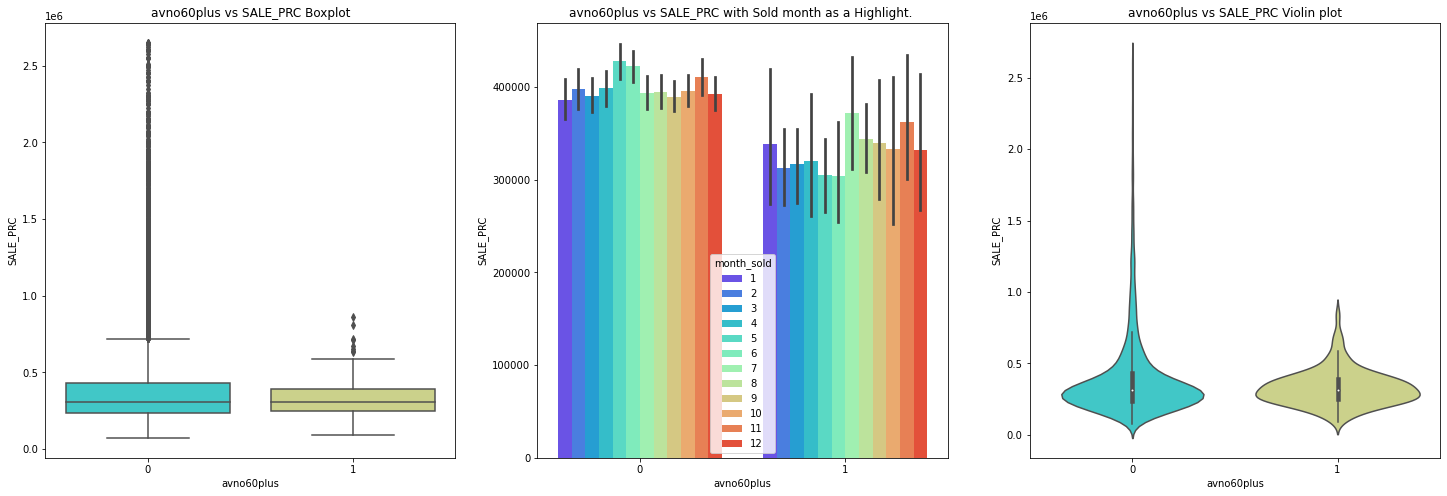

sub_class  count_Percentage
0          0              99.0
1          1               1.0

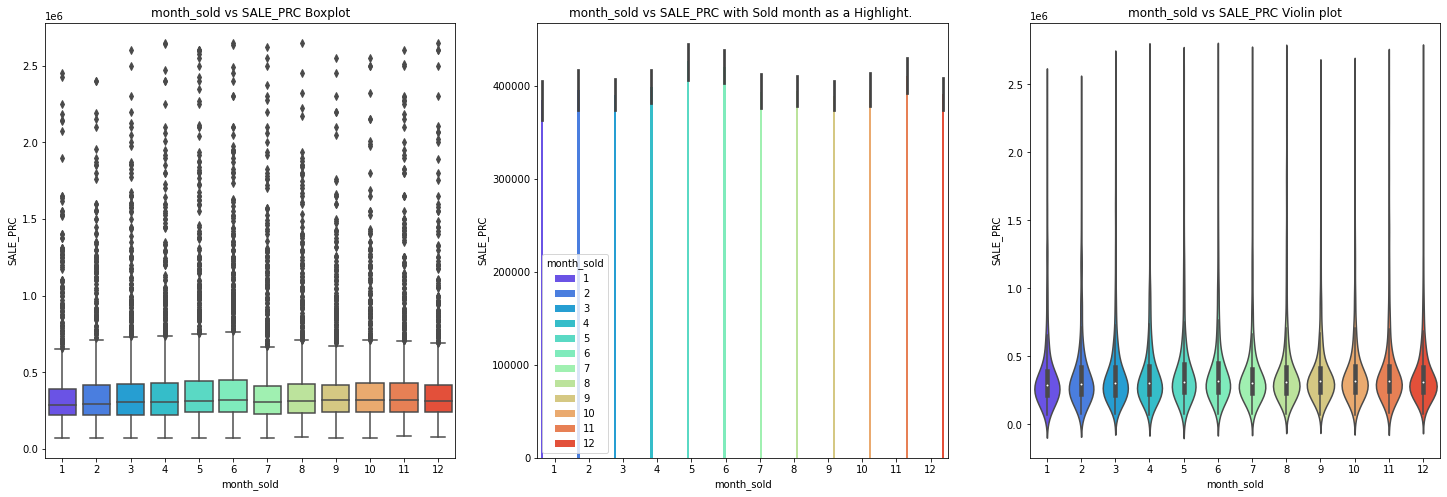

sub_class  count_Percentage
0           8               9.0
1           9               9.0
2           2               7.0
3           7               9.0
4           3               9.0
5          11               8.0
6           6              10.0
7          10               8.0
8           5               9.0
9          12               8.0
10          1               6.0
11          4               9.0

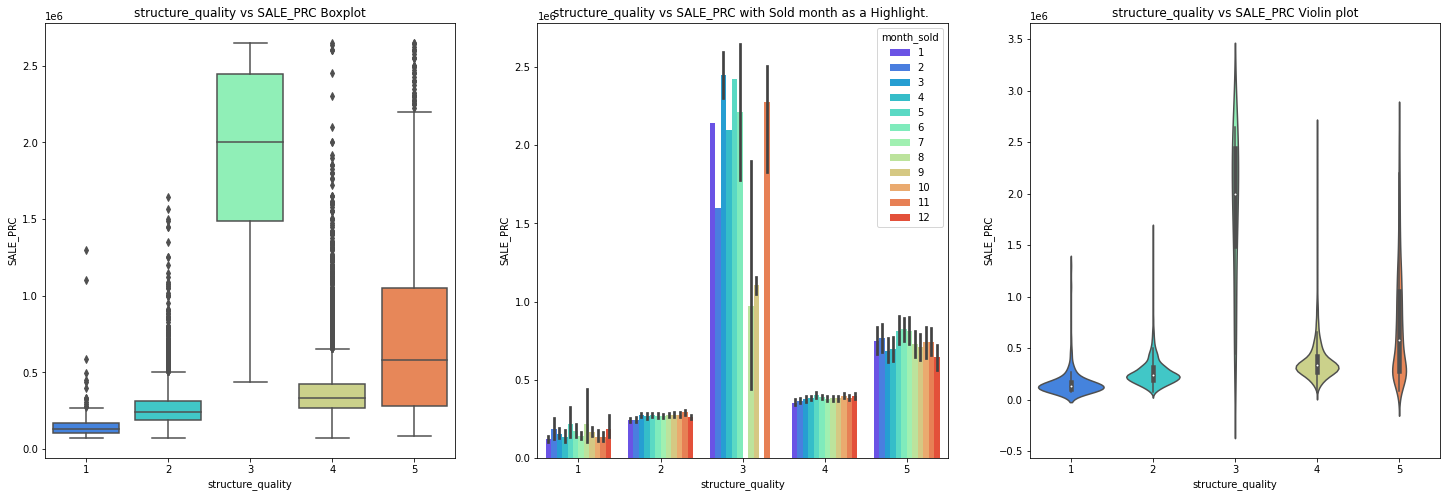

sub_class  count_Percentage
0          4              55.0
1          5              14.0
2          2              30.0
3          1               1.0
4          3               0.0

In [30]:
for col in df_cat.columns:
    cat_plots(df_cat.join(df['SALE_PRC']), col, "SALE_PRC")

1. month_sold : doesn't impact the SALE_PRC.
2. avno60plus : clearly Higher prices of house situated in low airplane noise zone.
    - Also: very less record for houses in high airplane noise zone almost only 1% ,hence less sure on the outcome.
3. structure_quality : based on (quality=2,4,5) we can say higher the quality more the price of the house which is also a common trend.

## Multicollinearity Test.

In [31]:
def calculate_vif(dataset):
    vif = pd.DataFrame()
    vif['features'] = dataset.columns
    vif['VIF_Values'] = [variance_inflation_factor(dataset.values, i) for i in range(dataset.shape[1])]
    vif['VIF_Values'] = round(vif['VIF_Values'] , 2)
    vif = vif.sort_values(by = 'VIF_Values' , ascending = False)
    return (vif)

In [32]:
calculate_vif(df_num)

features  VIF_Values
1       LONGITUDE   230681.38
0        LATITUDE   227286.69
9       CNTR_DIST      141.75
10     SUBCNTR_DI       49.62
4    TOT_LVG_AREA       19.78
7      OCEAN_DIST       11.31
2        SALE_PRC        7.51
8      WATER_DIST        7.19
12            age        5.69
3      LND_SQFOOT        4.60
6       RAIL_DIST        4.00
11       HWY_DIST        3.60
5   SPEC_FEAT_VAL        2.24

## Applying PCA to treat Multicollinearity

In [33]:
def custom_PCA(X):
    n_comp = len(X.columns)
    
    # Appyling standardSCaler for feature scaking 
    sc = StandardScaler()
    X = sc.fit_transform(X)
    
    for i in range(1, n_comp):
        pca = PCA(n_components = i)
        p_comp = pca.fit_transform(X) 
        evr = np.cumsum(pca.explained_variance_ratio_) # evr is cumulative sum of  iteration
        if evr[i-1] > 0.98:
            pcs = i
            break
    print('Explained variance ratio after PCA is:' , evr)
    
    #creating a dataframe of principal components
    col = []
    for j in range(1,pcs+1): 
        col.append('PC_' + str(j))
    pca_df = pd.DataFrame(p_comp, columns= col)
    return pca_df

In [34]:
pca_df = custom_PCA(df_num)

Explained variance ratio after PCA is: [0.31621273 0.52677335 0.63250459 0.73249098 0.79962419 0.85126645
 0.89866457 0.93888977 0.96500342 0.98163796]


## Creating Final Dataset.

In [35]:
X = pca_df.join(df_cat)

In [36]:
X = X.join(df["SALE_PRC"])

In [37]:
X.head()

PC_1      PC_2      PC_3      PC_4      PC_5      PC_6      PC_7  \
0 -2.889070 -0.384618  0.553686 -0.406504  0.191503  1.655931  1.151507   
1 -2.761075 -0.431171  0.588183 -0.454694  0.116717  1.993347  1.233359   
2 -2.937782  2.147703  0.469034  0.792427  0.036691  0.999157  0.659999   
3 -3.027179  1.286005  0.421675  0.124042 -0.078800  2.068872  1.033669   
4 -2.679603  1.043959  0.333402  0.104778 -0.252440  1.515168  1.371292   

       PC_8      PC_9     PC_10  avno60plus  month_sold  structure_quality  \
0  0.225365 -0.776291 -0.105853           0           8                  4   
1  0.394336 -0.500293 -0.385648           0           9                  4   
2  2.664555 -0.792232  0.084996           0           2                  4   
3  0.292442 -0.809342  0.794905           0           9                  4   
4  0.813523  0.172176  0.467029           0           7                  4   

   SALE_PRC  
0  440000.0  
1  349000.0  
2  800000.0  
3  988000.0  
4  755000.0

## Model Building.

In [38]:
def train_and_test_split(data, tcol , testSize = 0.3 , randomState = 3):
    X = data.drop(tcol, axis=1)
    y = data[tcol]
    return train_test_split(X,y , test_size = testSize , random_state = randomState)


In [39]:
def model_builder(model_name, model, data, t_col):
    X_train, X_test, y_train, y_test = train_and_test_split(data,t_col)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    result = [model_name, rmse, r2]
    return result

In [40]:
model_builder("LinearRegression", model=LinearRegression(), data=X, t_col="SALE_PRC")

['LinearRegression', 17838.99042379119, 0.9967933424203941]

In [41]:
def multiple_models(data, t_col):
    col_names = ['Model Name' , 'RMSE' , 'R2 Score']
    result = pd.DataFrame(columns = col_names)
    result.loc[len(result)] = model_builder('LinearRegression' , LinearRegression() , data , t_col)
    result.loc[len(result)] = model_builder('Lasso' , Lasso() , data , t_col)
    result.loc[len(result)] = model_builder('Ridge' , Ridge() , data , t_col)
    result.loc[len(result)] = model_builder('DTR' , DecisionTreeRegressor() , data , t_col)
    result.loc[len(result)] = model_builder('SVR' , SVR() , data , t_col)
    result.loc[len(result)] = model_builder('Random Forest' , RandomForestRegressor() , data , t_col)
    result.loc[len(result)] = model_builder('KNN' , KNeighborsRegressor() , data , t_col)
    result.loc[len(result)] = model_builder('Gboost' , GradientBoostingRegressor() , data , t_col)
    result.loc[len(result)] = model_builder('XGboost' , XGBRegressor() , data , t_col)
    result.loc[len(result)] = model_builder('Adaboost' , AdaBoostRegressor() , data , t_col)

    return result.sort_values('R2 Score' , ascending = False)


In [42]:
multiple_models(X, "SALE_PRC")

Model Name           RMSE  R2 Score
2             Ridge   17838.933934  0.996793
0  LinearRegression   17838.990424  0.996793
1             Lasso   17838.998151  0.996793
8           XGboost   40931.067852  0.983118
5     Random Forest   52889.436809  0.971813
7            Gboost   52992.565932  0.971703
6               KNN   69837.317664  0.950854
3               DTR   83988.489040  0.928919
9          Adaboost  129881.425018  0.830017
4               SVR  327897.008265 -0.083395

In [43]:
def k_fold_cv(X, y , fold = 10):
    score_LR = cross_val_score(LinearRegression() , X, y , cv= fold)
    score_LS = cross_val_score(Lasso() , X, y , cv= fold)
    score_RD = cross_val_score(Ridge() , X, y , cv= fold)
    score_DTR = cross_val_score(DecisionTreeRegressor() , X, y , cv= fold)
    score_SVR = cross_val_score(SVR() , X, y , cv= fold)
    score_RandomForest = cross_val_score(RandomForestRegressor() , X, y , cv= fold)
    score_KNN = cross_val_score(KNeighborsRegressor() , X, y , cv= fold)
    score_Gboost = cross_val_score(GradientBoostingRegressor() , X, y , cv= fold)
    score_XGBoost = cross_val_score(XGBRegressor() , X, y , cv= fold)
    score_AdaBoost = cross_val_score(AdaBoostRegressor() , X, y , cv= fold)
    
    
    model_name = ['Linear regression' , 'Lasso' , 'Ridge' , 'DTR' , 'SVR' , 'Random Forest' , 'KNN' , 'Gboost' , 'XGBoost' , 'AdaBoost']
    scores = [score_LR , score_LS , score_RD, score_DTR, score_SVR ,score_RandomForest, score_KNN, score_Gboost, score_XGBoost, score_AdaBoost]  
    result = []
    
    for i in range(len(model_name)):
        score_mean = np.mean(scores[i])
        score_std = np.std(scores[i])
        m_name = model_name[i]
        temp = [m_name , score_mean , score_std]
        result.append(temp)
    k_fold_df = pd.DataFrame(result, columns = ['Model Name' , 'CV Accuracy' , 'CV STD'])
    return k_fold_df.sort_values('CV Accuracy' , ascending = False)
                                                                                                                          
    

In [44]:
k_fold_cv(X.drop('SALE_PRC' , axis =1) , X["SALE_PRC"])

Model Name  CV Accuracy    CV STD
0  Linear regression     0.972929  0.025974
1              Lasso     0.972929  0.025973
2              Ridge     0.972926  0.025972
8            XGBoost     0.876084  0.129073
7             Gboost     0.833375  0.199279
5      Random Forest     0.824588  0.132823
6                KNN     0.775669  0.122525
3                DTR     0.646005  0.248825
4                SVR    -0.282761  0.211831
9           AdaBoost    -0.563887  1.973910

## Hyperparameter Tuning

- Selecting the best 3
   - Lasso and Ridge : as Linear Regressor dont have any hyperparameter to tune.

In [45]:
def tuning(X, y, fold=10):
    #parameters grid for tuning
    param_Lasso = {'alpha': [0,1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,50], 'selection':['cyclic', 'random']}
    param_Ridge = {'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg'], 'alpha': [0,1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,50]}
    
    #Hyperparameter Tuning
    tune_Lasso = GridSearchCV(Lasso(), param_Lasso, cv = fold)
    tune_Ridge = GridSearchCV(Ridge(), param_Ridge, cv = fold)
    
    #Fitting X and Y
    tune_Lasso.fit(X,y)
    tune_Ridge.fit(X,y)
    
    tune = [tune_Lasso, tune_Ridge]
    models = ['Lasso', 'Ridge']
    
    for i in range(len(tune)):
        print('models: ', models[i])
        print('best Parameters: ', tune[i].best_params_)
        
    

In [46]:
tuning(X.drop('SALE_PRC' , axis =1) , X["SALE_PRC"])

models:  Lasso
best Parameters:  {'alpha': 20, 'selection': 'random'}
models:  Ridge
best Parameters:  {'alpha': 0, 'solver': 'lsqr'}


## Post Hyperparameter Tuning.

In [49]:
def  cv_post_hpt(X,y, fold = 10):
    score_LS = cross_val_score(Lasso(alpha=20, selection='random') , X, y , cv= fold)
    score_RD = cross_val_score(Ridge(alpha=0, solver='lsqr') , X, y , cv= fold)
    
    model_name = ['Lasso' , 'Ridge']
    scores = [score_LS , score_RD]  
    result = []
    
    for i in range(len(model_name)):
        score_mean = np.mean(scores[i])
        score_std = np.std(scores[i])
        m_name = model_name[i]
        temp = [m_name , score_mean , score_std]
        result.append(temp)
    k_fold_df = pd.DataFrame(result, columns = ['Model Name' , 'CV Accuracy' , 'CV STD'])
    return k_fold_df.sort_values('CV Accuracy' , ascending = False)
                       

In [50]:
cv_post_hpt(X.drop('SALE_PRC' , axis =1) , X["SALE_PRC"])

Model Name  CV Accuracy    CV STD
1      Ridge     0.972940  0.025974
0      Lasso     0.972934  0.025945

## Conclusion.

- Linear Regression, Lasso and Ridge is Performing Best.